In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd


import numpy as np

import seaborn as sns

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('ipl.csv')
df.head()

,mid,date,venue,bat_team,bowl_team,batsman,bowler,runs,wickets,overs,runs_last_5,wickets_last_5,striker,non-striker,total
0,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,SC Ganguly,P Kumar,1,0,0.1,1,0,0,0,222
1,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,1,0,0.2,1,0,0,0,222
2,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.2,2,0,0,0,222
3,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.3,2,0,0,0,222
4,1,2008-04-18,M Chinnaswamy Stadium,Kolkata Knight Riders,Royal Challengers Bangalore,BB McCullum,P Kumar,2,0,0.4,2,0,0,0,222


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76014 entries, 0 to 76013
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   mid             76014 non-null  int64  
 1   date            76014 non-null  object 
 2   venue           76014 non-null  object 
 3   bat_team        76014 non-null  object 
 4   bowl_team       76014 non-null  object 
 5   batsman         76014 non-null  object 
 6   bowler          76014 non-null  object 
 7   runs            76014 non-null  int64  
 8   wickets         76014 non-null  int64  
 9   overs           76014 non-null  float64
 10  runs_last_5     76014 non-null  int64  
 11  wickets_last_5  76014 non-null  int64  
 12  striker         76014 non-null  int64  
 13  non-striker     76014 non-null  int64  
 14  total           76014 non-null  int64  
dtypes: float64(1), int64(8), object(6)
memory usage: 8.7+ MB


In [4]:
df.columns



Index(['mid', 'date', 'venue', 'bat_team', 'bowl_team', 'batsman', 'bowler',
       'runs', 'wickets', 'overs', 'runs_last_5', 'wickets_last_5', 'striker',
       'non-striker', 'total'],
      dtype='object')

In [5]:
df.drop(['mid', 'venue', 'batsman', 'bowler', 'striker', 'non-striker'], axis=1, inplace=True)
df.head()

,date,bat_team,bowl_team,runs,wickets,overs,runs_last_5,wickets_last_5,total
0,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.1,1,0,222
1,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,1,0,0.2,1,0,222
2,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.2,2,0,222
3,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.3,2,0,222
4,2008-04-18,Kolkata Knight Riders,Royal Challengers Bangalore,2,0,0.4,2,0,222


In [6]:
consider_teams = ['Kolkata Knight Riders', 'Chennai Super Kings', 'Rajasthan Royals',
                    'Mumbai Indians', 'Kings XI Punjab', 'Royal Challengers Bangalore',
                    'Delhi Daredevils', 'Sunrisers Hyderabad']
df = df[(df['bat_team'].isin(consider_teams)) & (df['bowl_team'].isin(consider_teams))]

In [7]:
df = df[df['overs']>=5.0]

# Converting the column 'date' from string into datetime object
from datetime import datetime
df['date'] = df['date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [8]:
df.duplicated().sum()

0

In [9]:
print('After cleaning the data: {}'.format(df.shape))

After cleaning the data: (40108, 9)


<AxesSubplot:>

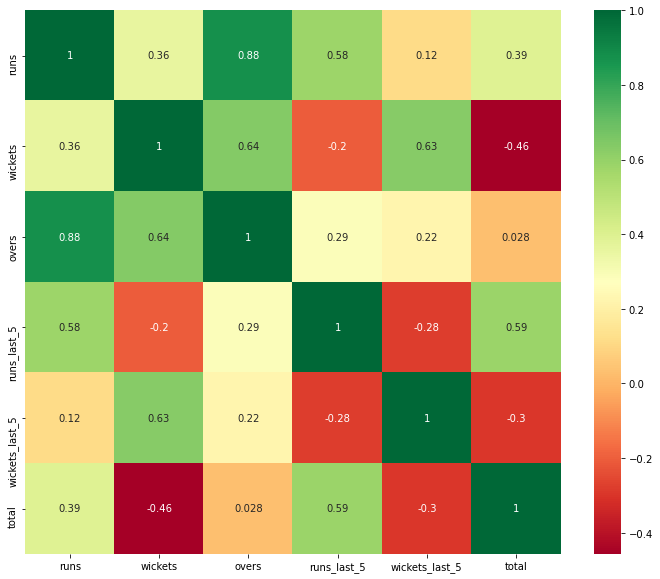

In [10]:
corrmat = df.corr()
plt.figure(figsize=(12,10))
# plot heat map
sns.heatmap(corrmat, annot=True, cmap="RdYlGn")

In [11]:
Dummies = pd.get_dummies(df[['bat_team', 'bowl_team']])
df = df.drop(['bat_team', 'bowl_team'], axis = 1)
df= pd.concat([df, Dummies], axis = 1)

In [12]:
df.shape

(40108, 23)

In [13]:

train_data = df[df['date'].dt.year <= 2016]
test_data = df[df['date'].dt.year >=2017]

X_train = train_data.drop(['total', 'date'], axis=1)
X_test = test_data.drop(['total', 'date'], axis=1)

y_train = train_data['total']
y_test = test_data['total']


In [14]:
from sklearn.linear_model import LinearRegression
lr_clf = LinearRegression()
lr_clf.fit(X_train,y_train)
lr_clf.score(X_test,y_test)

0.7522633566350542

In [15]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

cross_val_score(LinearRegression(), X_train,y_train , cv=cv)

array([0.64765331, 0.66015337, 0.64027021, 0.65564667, 0.64448271])

In [16]:
from sklearn.ensemble import ExtraTreesRegressor
model = ExtraTreesRegressor()
model.fit(X_train,y_train)

ExtraTreesRegressor()

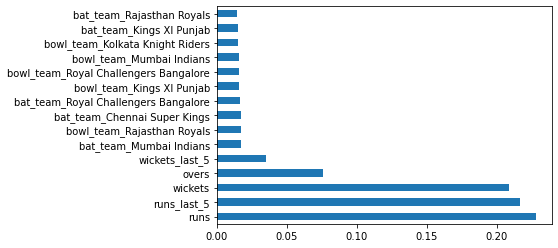

In [17]:
feat_importances = pd.Series(model.feature_importances_, index=X_train.columns)
feat_importances.nlargest(15).plot(kind='barh')
plt.show()

In [18]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

def find_best_model_using_gridsearchcv(X,y):
    algos = {
        'linear_regression' : {
            'model': LinearRegression(),
            'params': {
                'normalize': [True, False]
            }
        },
        'lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random', 'cyclic']
            }
        },
        'decision_tree': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion' : ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        }
    }
    scores = []
    cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
    for algo_name, config in algos.items():
        gs =  GridSearchCV(config['model'], config['params'], cv=cv, return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model': algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })

    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_using_gridsearchcv(X_train,y_train)

,model,best_score,best_params
0,linear_regression,0.649641,{'normalize': False}
1,lasso,0.637299,"{'alpha': 1, 'selection': 'cyclic'}"
2,decision_tree,0.898351,"{'criterion': 'friedman_mse', 'splitter': 'ran..."


In [20]:
df


,date,runs,wickets,overs,runs_last_5,wickets_last_5,total,bat_team_Chennai Super Kings,bat_team_Delhi Daredevils,bat_team_Kings XI Punjab,...,bat_team_Royal Challengers Bangalore,bat_team_Sunrisers Hyderabad,bowl_team_Chennai Super Kings,bowl_team_Delhi Daredevils,bowl_team_Kings XI Punjab,bowl_team_Kolkata Knight Riders,bowl_team_Mumbai Indians,bowl_team_Rajasthan Royals,bowl_team_Royal Challengers Bangalore,bowl_team_Sunrisers Hyderabad
32,2008-04-18,61,0,5.1,59,0,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
33,2008-04-18,61,1,5.2,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
34,2008-04-18,61,1,5.3,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
35,2008-04-18,61,1,5.4,59,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
36,2008-04-18,61,1,5.5,58,1,222,0,0,0,...,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75884,2017-05-19,106,9,18.1,29,4,107,0,0,0,...,0,0,0,0,0,0,1,0,0,0
75885,2017-05-19,107,9,18.2,29,4,107,0,0,0,...,0,0,0,0,0,0,1,0,0,0
75886,2017-05-19,107,9,18.3,28,4,107,0,0,0,...,0,0,0,0,0,0,1,0,0,0
75887,2017-05-19,107,9,18.4,24,4,107,0,0,0,...,0,0,0,0,0,0,1,0,0,0


In [35]:
regressor = DecisionTreeRegressor(criterion= 'friedman_mse',random_state = 0,splitter= 'random') 
  
# fit the regressor with X and Y data
regressor.fit(X_train, y_train)


DecisionTreeRegressor(criterion='friedman_mse', random_state=0,
                      splitter='random')

In [25]:
pred = regressor.predict(X_train)

In [26]:
from sklearn import metrics
print('Train RMSE:', np.sqrt(metrics.mean_squared_error(y_train, pred)))

Train RMSE: 0.3547730491752566


In [27]:
predict=regressor.predict(X_test)

<AxesSubplot:xlabel='total', ylabel='Density'>

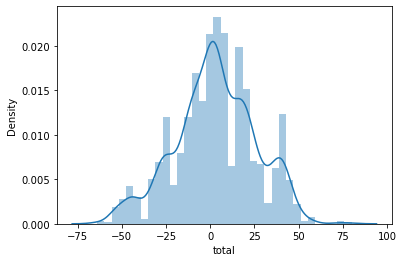

In [28]:
import seaborn as sns
sns.distplot(y_test-predict)

In [29]:
print('MAE:', metrics.mean_absolute_error(y_test, predict))
print('MSE:', metrics.mean_squared_error(y_test, predict))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predict)))

MAE: 18.09143268538517
MSE: 533.7552195824334
RMSE: 23.103143067176667


In [43]:
def predict_score(batting_team='Chennai Super Kings', bowling_team='Mumbai Indians', overs=5.1, runs=50, wickets=0, runs_in_prev_5=50, wickets_in_prev_5=0):
  temp_array = list()

  # Batting Team
  if batting_team == 'Chennai Super Kings':
    temp_array = temp_array + [1,0,0,0,0,0,0,0]
  elif batting_team == 'Delhi Daredevils':
    temp_array = temp_array + [0,1,0,0,0,0,0,0]
  elif batting_team == 'Kings XI Punjab':
    temp_array = temp_array + [0,0,1,0,0,0,0,0]
  elif batting_team == 'Kolkata Knight Riders':
    temp_array = temp_array + [0,0,0,1,0,0,0,0]
  elif batting_team == 'Mumbai Indians':
    temp_array = temp_array + [0,0,0,0,1,0,0,0]
  elif batting_team == 'Rajasthan Royals':
    temp_array = temp_array + [0,0,0,0,0,1,0,0]
  elif batting_team == 'Royal Challengers Bangalore':
    temp_array = temp_array + [0,0,0,0,0,0,1,0]
  elif batting_team == 'Sunrisers Hyderabad':
    temp_array = temp_array + [0,0,0,0,0,0,0,1]

  # Bowling Team
  if bowling_team == 'Chennai Super Kings':
    temp_array = temp_array + [1,0,0,0,0,0,0,0]
  elif bowling_team == 'Delhi Daredevils':
    temp_array = temp_array + [0,1,0,0,0,0,0,0]
  elif bowling_team == 'Kings XI Punjab':
    temp_array = temp_array + [0,0,1,0,0,0,0,0]
  elif bowling_team == 'Kolkata Knight Riders':
    temp_array = temp_array + [0,0,0,1,0,0,0,0]
  elif bowling_team == 'Mumbai Indians':
    temp_array = temp_array + [0,0,0,0,1,0,0,0]
  elif bowling_team == 'Rajasthan Royals':
    temp_array = temp_array + [0,0,0,0,0,1,0,0]
  elif bowling_team == 'Royal Challengers Bangalore':
    temp_array = temp_array + [0,0,0,0,0,0,1,0]
  elif bowling_team == 'Sunrisers Hyderabad':
    temp_array = temp_array + [0,0,0,0,0,0,0,1]

  # Overs, Runs, Wickets, Runs_in_prev_5, Wickets_in_prev_5
  temp_array = temp_array + [overs, runs, wickets, runs_in_prev_5, wickets_in_prev_5]

  # Converting into numpy array
  temp_array = np.array([temp_array])

  # Prediction
  return int(lr_clf.predict(temp_array)[0])

In [44]:
final_score = predict_score(batting_team='Kolkata Knight Riders', bowling_team='Royal Challengers Bangalore', overs=10.1, runs=88, wickets=2, runs_in_prev_5=50, wickets_in_prev_5=1)
print("The final predicted score (range): {} to {}".format(final_score-10, final_score+5))

The final predicted score (range): 174 to 189


In [45]:
final_score = predict_score(batting_team='Rajasthan Royals', bowling_team='Kolkata Knight Riders', overs=13.1, runs=100, wickets=3, runs_in_prev_5=42, wickets_in_prev_5=2)
print("The final predicted score (range): {} to {}".format(final_score-10, final_score+5))

The final predicted score (range): 164 to 179


In [46]:
final_score = predict_score(batting_team='Delhi Daredevils', bowling_team='Chennai Super Kings', overs=10.2, runs=68, wickets=3, runs_in_prev_5=29, wickets_in_prev_5=1)
print("The final predicted score (range): {} to {}".format(final_score-10, final_score+5))

The final predicted score (range): 147 to 162
